In [37]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import ctables
import numpy as np
import scipy.ndimage as ndimage
import cdsapi
import fsspec
import xarray as xr
import matplotlib.colors as mcolors
import os
import pandas as pd

from palettable.colorbrewer.diverging import RdBu_11_r

In [60]:
case_date = "2022-12-21"

case_date = pd.to_datetime(case_date, format="%Y-%m-%d")
case_date_m1 = case_date - pd.Timedelta(hours=24)

### range of dates we want to plot
dates = pd.date_range(start=case_date - pd.Timedelta(hours=24), 
                      end=case_date + pd.Timedelta(hours=24), freq="24H")

dates

DatetimeIndex(['2022-12-20', '2022-12-21', '2022-12-22'], dtype='datetime64[ns]', freq='24H')

In [12]:
## set some plt defaults
plt.rcParams['savefig.facecolor'] = "white"
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['savefig.dpi'] = 200

# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plots
plotcrs = ccrs.LambertConformal(central_latitude=45, central_longitude=-100)

## endash:
enDash = u'\u2013'

In [61]:
#Data Acquisition
 
print("getting pressure level data")

c1 = cdsapi.Client()
name = 'reanalysis-era5-pressure-levels'
request = {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            'geopotential', 'relative_humidity', 'temperature',
            'u_component_of_wind', 'v_component_of_wind',
        ],
        'pressure_level': [
            '250', '500', '700',
            '850', '925', '1000',
        ],
        ### use the 'dates' array above to build the list of dates we want
        'date': dates[0].strftime("%Y-%m-%d")+"/"+dates[-1].strftime("%Y-%m-%d"),
        'time': [
                '00:00', '06:00', '12:00', '18:00',
            ],
        'area'          : [75.,185, 15., 320.] #N,W,S,E
}
r1 = c1.retrieve(name, request, None)

with fsspec.open(r1.location) as f1:
    iso_vars = xr.open_dataset(f1, engine='scipy')
#    print(iso_vars)

iso_vars.to_netcdf("iso_vars_"+case_date.strftime("%Y%m%d")+".nc")


getting pressure level data


2024-01-19 16:25:06,525 INFO Welcome to the CDS
2024-01-19 16:25:06,526 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2024-01-19 16:25:06,736 INFO Request is queued
2024-01-19 16:25:28,450 INFO Request is running
2024-01-19 16:25:57,232 INFO Request is completed


In [62]:
## pull out needed variables
lon = iso_vars_this.longitude.data
lat = iso_vars_this.latitude.data

working on 0000 UTC 22 Dec 2022


working on 0000 UTC 21 Dec 2022
plotting 250 wind speed
plotting 850 temperature
working on 0000 UTC 22 Dec 2022
plotting 250 wind speed
plotting 850 temperature


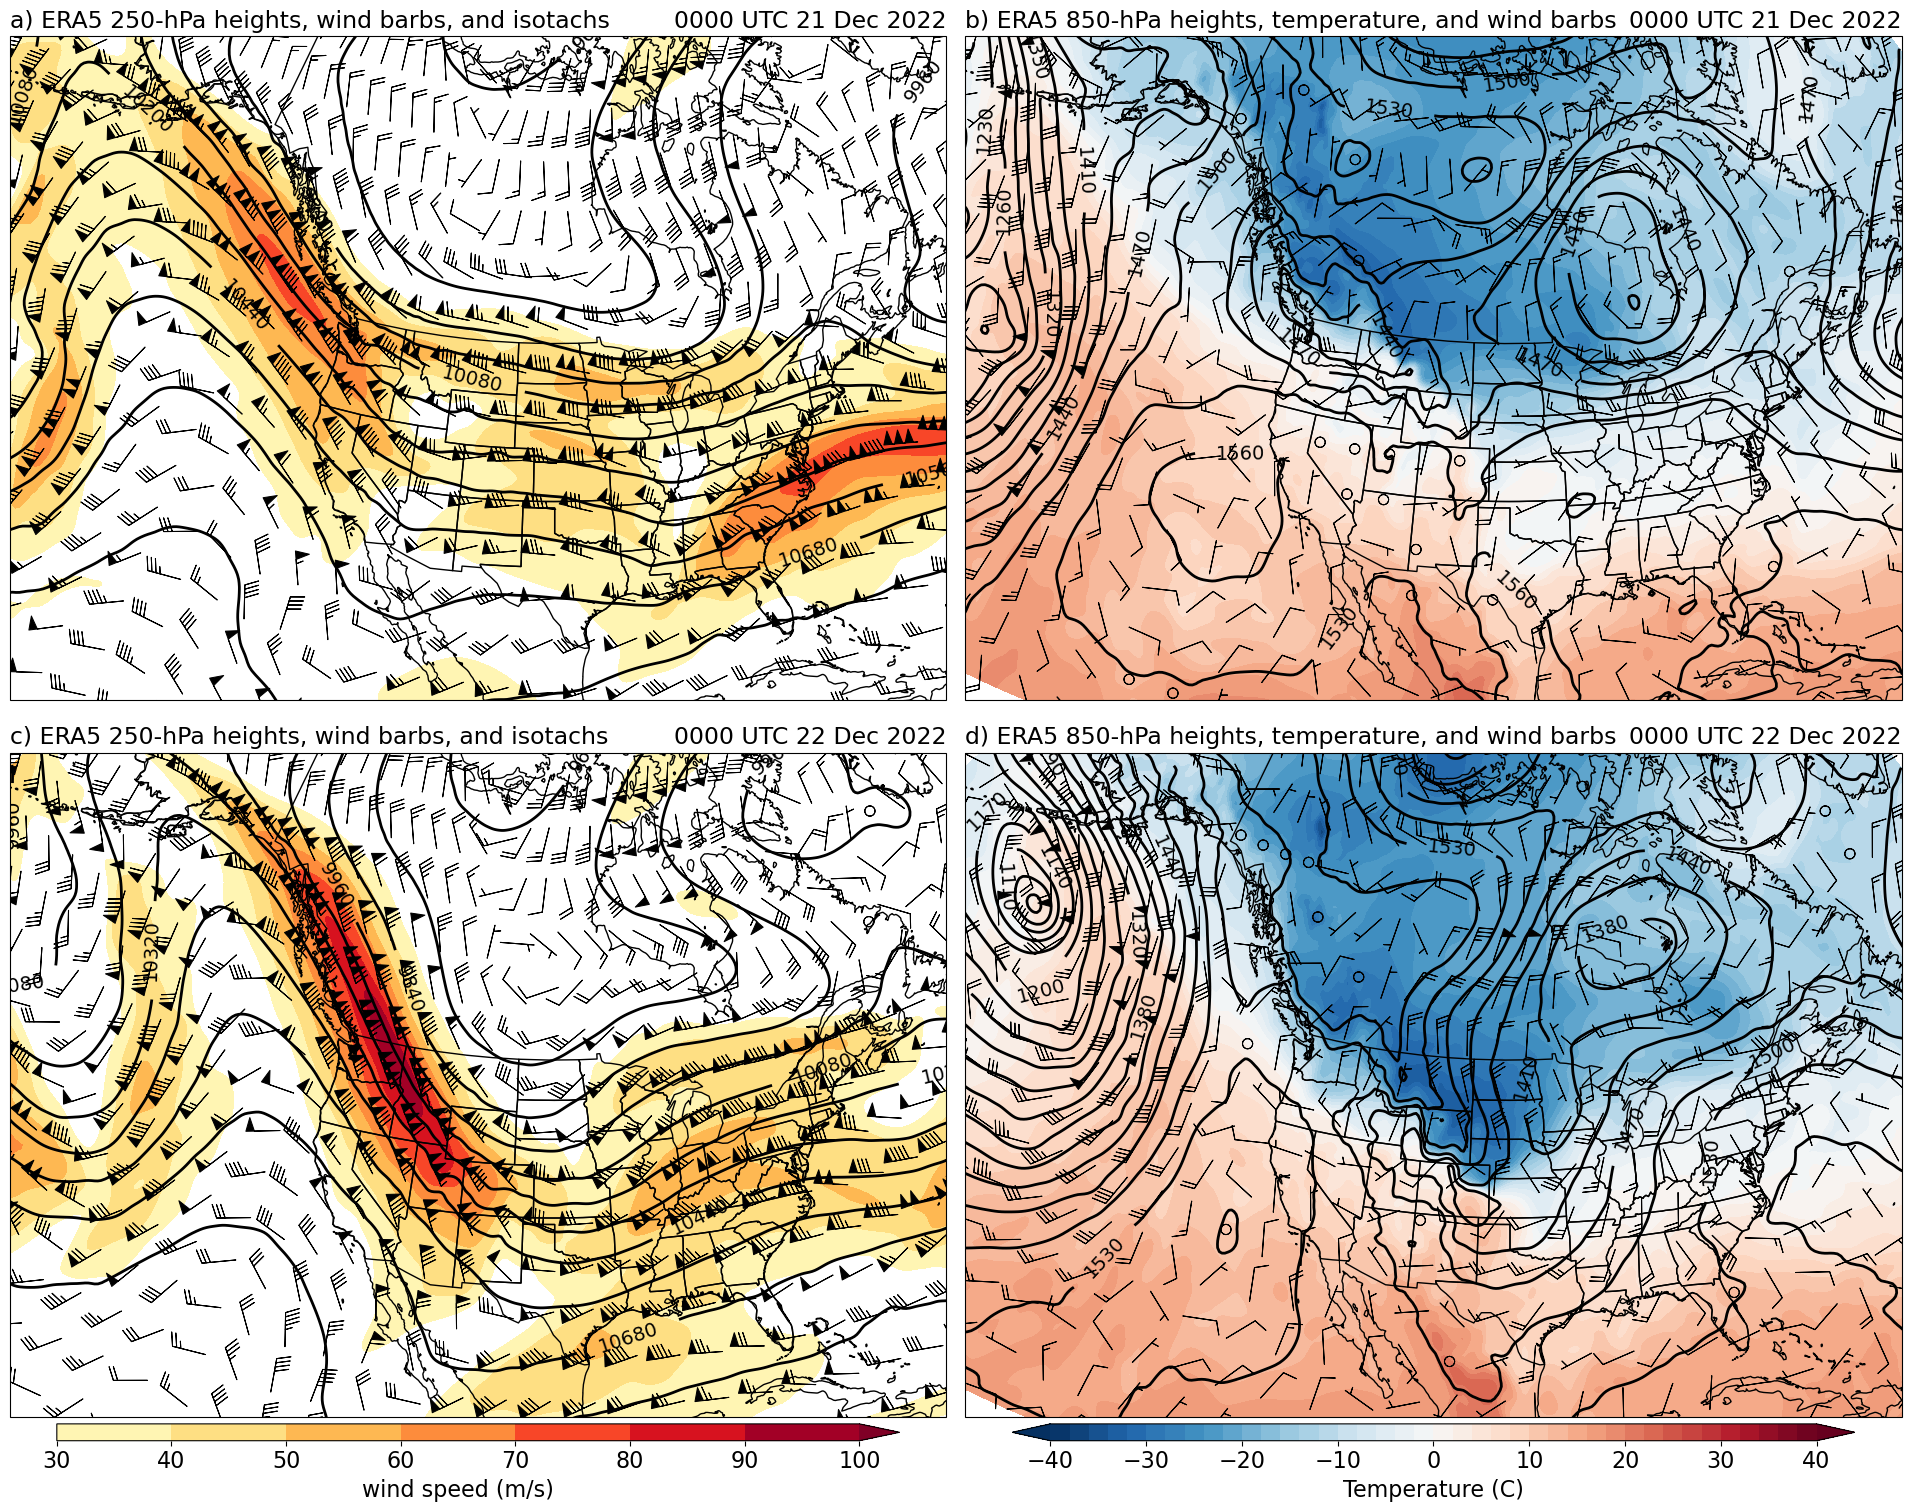

In [108]:
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(19, 15), constrained_layout=True,
                          subplot_kw={'projection': plotcrs})

axlist = axarr.flatten()

first_time = True

for this_time in [pd.Timestamp(2022,12,21,0),pd.Timestamp(2022,12,22,0)]:

    iso_vars_this = iso_vars.sel(time=this_time)
    #sl_vars_this = sl_vars.sel(time=this_time)
    vtime = pd.to_datetime(iso_vars_this.time.values)

    print("working on "+vtime.strftime("%H%M UTC %d %b %Y"))

    if first_time:
        ax_index = 0
        ax_label1 = "a)"
        ax_label2 = "b)"
    else:
        ax_index = 2
        ax_label1 = "c)"
        ax_label2 = "d)"
    
    hght_250 = iso_vars_this.z.sel(level=250)/9.81  ## this was geopotential, convert to geopotential height
    uwnd_250 = iso_vars_this.u.sel(level=250)
    vwnd_250 = iso_vars_this.v.sel(level=250)
    tmpk_250 = iso_vars_this.t.sel(level=250)
    
    # Use MetPy to calculate the wind speed for colorfill plot
    sped_250 = mpcalc.wind_speed(uwnd_250, vwnd_250)
    sped_250 = ndimage.gaussian_filter(sped_250, sigma=2, order=0) * units('m/s')
    
    ## smooth the height, u and v
    hght_250 = ndimage.gaussian_filter(hght_250, sigma=1, order=0) * units('m')
    uwnd_250 = ndimage.gaussian_filter(uwnd_250, sigma=1, order=0) * units('m/s')
    vwnd_250 = ndimage.gaussian_filter(vwnd_250, sigma=1, order=0) * units('m/s')
    
    ### repeat for 850
    hght_850 = iso_vars_this.z.sel(level=850)/9.81  ## this was geopotential, convert to geopotential height
    uwnd_850 = iso_vars_this.u.sel(level=850)
    vwnd_850 = iso_vars_this.v.sel(level=850)
    tmpk_850 = iso_vars_this.t.sel(level=850)
    
    ## smooth the temperature 
    tmpk_850 = ndimage.gaussian_filter(tmpk_850, sigma=1, order=0) * units('kelvin')
    tmpc_850 = tmpk_850.to(units('degC'))
    hght_850 = ndimage.gaussian_filter(hght_850, sigma=1, order=0) * units('m')
    
    ## give units to winds & smooth slightly
    uwnd_850 = ndimage.gaussian_filter(uwnd_850, sigma=1, order=0) * units('m/s')
    vwnd_850 = ndimage.gaussian_filter(vwnd_850, sigma=1, order=0) * units('m/s')
    
    #Map Creation
    
    print('plotting 250 wind speed')
    
    # Plot Titles
    axlist[0+ax_index].set_title(ax_label1+" ERA5 250-hPa heights, wind barbs, and isotachs",
              loc='left', fontsize=17)
    axlist[0+ax_index].set_title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=17)
    
    # Plot Background
    axlist[0+ax_index].set_extent([217.5, 290., 18., 66.])
    axlist[0+ax_index].coastlines('50m', edgecolor='black', linewidth=1)
    axlist[0+ax_index].add_feature(cfeature.STATES, linewidth=1)
    
    # Plot Height Contours
    clev250 = np.arange(6000, 21001, 120)
    cs = axlist[0+ax_index].contour(lon, lat, hght_250, clev250, colors='black', linewidths=2,
                    linestyles='solid', transform=ccrs.PlateCarree())
    plt.clabel(cs, fontsize=14, inline=1, inline_spacing=8, fmt='%i', 
                    rightside_up=True, use_clabeltext=True)
    
    # Plot Colorfill Wind Speeds in m/s
    clevs_250_sped = np.arange(30, 110, 10)
    cf = axlist[0+ax_index].contourf(lon, lat, sped_250, clevs_250_sped, cmap=plt.cm.YlOrRd,extend='max',
                     transform=datacrs)

    if not first_time:
        cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50, shrink=0.9, ax=axlist[0+ax_index])
        cb.set_label('wind speed (m/s)', fontsize=16)
        cb.ax.tick_params(labelsize=16)
    
    # Plot Wind Barbs
    # Transform Vectors and plot wind barbs.
    wind_slice = slice(None, None, 14)
    axlist[0+ax_index].barbs(lon[wind_slice], lat[wind_slice], uwnd_250.to(units('kt'))[wind_slice,wind_slice].m, vwnd_250.to(units('kt'))[wind_slice,wind_slice].m, 
             length=7, linewidth=0.75,pivot='middle', transform=ccrs.PlateCarree())
    
    #### and 850-mb 
    
    print('plotting 850 temperature')
    
    # Plot Titles
    axlist[1+ax_index].set_title(ax_label2+" ERA5 850-hPa heights, temperature, and wind barbs",
              loc='left', fontsize=17)
    axlist[1+ax_index].set_title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=17)
    
    # Plot Background
    #axlist[1+ax_index].set_extent([227.5, 290., 20., 58.])
    axlist[1+ax_index].set_extent([217.5, 290., 18., 66.])
    axlist[1+ax_index].coastlines('50m', edgecolor='black', linewidth=1)
    axlist[1+ax_index].add_feature(cfeature.STATES, linewidth=1)
    
    # Plot Height Contours
    clev850 = np.arange(0, 3001, 30)
    cs2 = axlist[1+ax_index].contour(lon, lat, hght_850, clev850, colors='black', linewidths=2,
                    linestyles='solid', transform=ccrs.PlateCarree())
    plt.clabel(cs2, fontsize=14, inline=1, inline_spacing=8, fmt='%i',
               rightside_up=True, use_clabeltext=True)
    
    # Plot colorfill and dashed contours of 850-hPa temperatures in Celsius
    clevs_850_tmpc = np.arange(-40, 42, 2)
    cf2 = axlist[1+ax_index].contourf(lon, lat, tmpc_850, clevs_850_tmpc, 
                             #cmap=plt.cm.seismic, 
                             cmap = RdBu_11_r.mpl_colormap,
                             extend='both',
                     transform=datacrs)

    if not first_time:
        cb2 = plt.colorbar(cf2, orientation='horizontal', pad=0.01, aspect=50, shrink=0.9, ax=axlist[1+ax_index])
        cb2.set_label('Temperature (C)', fontsize=16)
        cb2.ax.tick_params(labelsize=16)
    
    ## plot the 0C line
    #clev_thk = [0]
    #cs4 = axlist[1+ax_index].contour(lon, lat, tmpc_850, clev_thk, colors='blue',
    #                 linewidths=2, transform=ccrs.PlateCarree())
    #plt.clabel(cs4, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
    #                 rightside_up=True, use_clabeltext=True)
    
    # Plot Wind Barbs
    # Transform Vectors and plot wind barbs.
    wind_slice = slice(None, None, 14)
    axlist[1+ax_index].barbs(lon[wind_slice], lat[wind_slice], uwnd_850.to(units('kt'))[wind_slice,wind_slice].m, vwnd_850.to(units('kt'))[wind_slice,wind_slice].m, 
             length=7, linewidth=0.75,pivot='middle', transform=ccrs.PlateCarree())

    first_time = False
    
plt.show()
plt.close('all')
outfile="4panel_era5_"+this_time.strftime('%Y%m%d')+"_"+this_time.strftime('%H%M')+".pdf"
fig.savefig(outfile)
#os.system("pngquant -f --ext .png "+outfile)
plt.close(fig)
